<img src="https://www.awi.de/typo3conf/ext/sms_boilerplate/Resources/Public/Images/AWI/awi_logo.svg" width=200 height=50 style="position:absolute; right:20px;">


# <center> Orbit & astronomical theroy of ice ages </center>

# Table of contents
   
1. [Introduction](#introduction) <br>
2. [Imports](#imports)<br>
3. [Plots](#plots)<br>
    3.1 [Insolation for 5.000 kys](#insol1)<br>
    3.2 [Orbital parameters](#orbitparam)<br>


# 1. Introduction <a name="introduction"></a>
This notebook serves as teaching material and support for lectures, as well as for further scientific education. it was developed for the course "Climate System 2 2021/2022" for the University of Bremen in the context of a HiWi activity at the Alfred-Wegener-Institute Bremerhaven. 

### Insolation calculation
<ul><li><a href="https://paleodyn.uni-bremen.de/gl/htmlR/astronomicalTheory_Berger.pdf" target="_blank">Overview article by A. Berger</a></li></ul>
Paleoclimatic reconstructions help to discover the natural variability of the climate system over times scales ranging from years to hundreds of thousands of years. They are fundamental in climate research, especially now, because they provide a unique set of data to validate models over climatic situations largely different from those of the last 150 years. The climatic situations of the last century are indeed available in great detail, but with a very poor diversity. Among the different modes of climatic variations, the glacial‐interglacial cycles have the advantage that they provide examples of extreme climates and that their primary astronomical cause is now pretty well known. The Astronomical Theory of paleoclimates aims indeed to explain these climatic variations occurring with quasi‐periodicities situated between tens and hundreds of thousands of years. Such variations are recorded in deep‐sea sediments, in ice sheets and in continental archives. The origin of these quasi‐cycles lies in the astronomically driven changes of the latitudinal and seasonal distribution of the energy that the Earth receives from the Sun. Milutin Milankovitch extensively published about this theory between 1920 and 1950, but the relationship between the astronomical parameters, insolation and climate, had already been suggested at the beginning of the nineteenth century. There were several authors who have contributed to what is now named (often improperly) the Milankovitch astronomical theory.

Other references:
<ul>
    <li>
        Berger A. and Loutre M.F. (1991). Insolation values for the climate of the last 10 million years. Quaternary Science Reviews, 10(4), 297-317.
    </li>
    <li>
        Berger A. (1978). Long-term variations of daily insolation and Quaternary climatic changes. Journal of Atmospheric Science, 35(12), 2362-2367.
    </li>
</ul>

_____
Notebook created by <a href="b-schwertfeger.de">Benjamin Thomas Schwertfeger</a> (November, 2021) <br>

<a href="mailto:benjamin.schwertfeger@awi.de">benjamin.schwertfeger@awi.de</a><br>
Alfred-Wegener-Institute <br>
Helmholtz Centre for Polar and Marine Research<br>
<br>
Bussestraße 24<br>
D-27570 Bremerhaven<br>
Germany<br>

_____

# 2. Imports <a name="imports"></a>

In [ ]:
import numpy as np
from scipy import stats, signal, fft, interpolate
import matplotlib.pyplot as plt
%matplotlib inline

___________
# 3. Functions

In [31]:
#source: https://github.com/telmo-correa/time-series-analysis/blob/master/Python/spectrum.py
def spec_pgram(x, xfreq=1, spans=None, kernel=None, taper=0.1, pad=0, fast=True, demean=False, detrend=True, 
               plot=True, **kwargs):
    """
    Computes the spectral density estimate using a periodogram.  Optionally, it also:
    - Uses a provided kernel window, or a sequence of spans for convoluted modified Daniell kernels.
    - Tapers the start and end of the series to avoid end-of-signal effects.
    - Pads the provided series before computation, adding pad*(length of series) zeros at the end.
    - Pads the provided series before computation to speed up FFT calculation.
    - Performs demeaning or detrending on the series.
    - Plots results.
    
    Implemented to ensure compatibility with R's spectral functions, as opposed to reusing scipy's periodogram.
    
    Adapted from R's stats::spec.pgram.
    """
    def daniell_window_modified(m):
        """ Single-pass modified Daniell kernel window.
        
        Weight is normalized to add up to 1, and all values are the same, other than the first and the
        last, which are divided by 2.
        """
        def w(k):
            return np.where(np.abs(k) < m, 1 / (2*m), np.where(np.abs(k) == m, 1/(4*m), 0))

        return w(np.arange(-m, m+1))

    def daniell_window_convolve(v):
        """ Convolved version of multiple modified Daniell kernel windows.
        
        Parameter v should be an iterable of m values.
        """
        
        if len(v) == 0:
            return np.r_[1]

        if len(v) == 1:
            return daniell_window_modified(v[0])

        return np.convolve(daniell_window_modified(v[0]), daniell_window_convolve(v[1:]))
    
    # Ensure we can store non-integers in x, and that it is a numpy object
    x = np.r_[x].astype('float64')
    original_shape = x.shape
    
    # Ensure correct dimensions
    assert len(original_shape) <= 2, "'x' must have at most 2 dimensions"
    while len(x.shape) < 2:
        x = np.expand_dims(x, axis=1)
        
    N, nser = x.shape
    N0 = N
    
    # Ensure only one of spans, kernel is provided, and build the kernel window if needed
    assert (spans is None) or (kernel is None), "must specify only one of 'spans' or 'kernel'"
    if spans is not None:
        kernel = daniell_window_convolve(np.floor_divide(np.r_[spans], 2))
        
    # Detrend or demean the series
    if detrend:
        t = np.arange(N) - (N - 1)/2
        sumt2 = N * (N**2 - 1)/12
        x -= (np.repeat(np.expand_dims(np.mean(x, axis=0), 0), N, axis=0) + np.outer(np.sum(x.T * t, axis=1), t/sumt2).T)
    elif demean:
        x -= np.mean(x, axis=0)
        
    # Compute taper and taper adjustment variables
    x = spec_taper(x, taper)
    u2 = (1 - (5/8) * taper * 2)
    u4 = (1 - (93/128) * taper * 2)
         
    # Pad the series with copies of the same shape, but filled with zeroes
    if pad > 0:
        x = np.r_[x, np.zeros((pad * x.shape[0], x.shape[1]))]
        N = x.shape[0]
        
    # Further pad the series to accelerate FFT computation
    if fast:
        newN = fft.next_fast_len(N, True)
        x = np.r_[x, np.zeros((newN - N, x.shape[1]))]
        N = newN
        
    # Compute the Fourier frequencies (R's spec.pgram convention style)
    Nspec = int(np.floor(N/2))
    freq = (np.arange(Nspec) + 1) * xfreq / N
    
    # Translations to keep same row / column convention as stats::mvfft
    xfft = fft.fft(x.T).T
    
    # Compute the periodogram for each i, j
    pgram = np.empty((N, nser, nser), dtype='complex')
    for i in range(nser):
        for j in range(nser):
            pgram[:, i, j] = xfft[:, i] * np.conj(xfft[:, j]) / (N0 * xfreq)
            pgram[0, i, j] = 0.5 * (pgram[1, i, j] + pgram[-1, i, j])
       
    if kernel is None:    
        # Values pre-adjustment
        df = 2
        bandwidth = np.sqrt(1 / 12)
    else:
        def conv_circular(signal, kernel):
            """
            Performs 1D circular convolution, in the same style as R::kernapply,
            assuming the kernel window is centered at 0.
            """
            pad = len(signal) - len(kernel)
            half_window = int((len(kernel) + 1) / 2)
            indexes = range(-half_window, len(signal) - half_window)
            orig_conv = np.real(fft.ifft(fft.fft(signal) * fft.fft(np.r_[np.zeros(pad), kernel])))
            return orig_conv.take(indexes, mode='wrap')
                
        # Convolve pgram with kernel with circular conv
        for i in range(nser):
            for j in range(nser):
                pgram[:, i, j] = conv_circular(pgram[:, i, j], kernel)
        
        df = 2 / np.sum(kernel**2)
        m = (len(kernel) - 1)/2
        k = np.arange(-m, m+1)
        bandwidth = np.sqrt(np.sum((1/12 + k**2) * kernel))
    
    df = df/(u4/u2**2)*(N0/N)
    bandwidth = bandwidth * xfreq/N
    
    # Remove padded results
    pgram = pgram[1:(Nspec+1), :, :]
    
    spec = np.empty((Nspec, nser))
    for i in range(nser):
        spec[:, i] = np.real(pgram[:, i, i])
    
    if nser == 1:
        coh = None
        phase = None
    else:
        coh = np.empty((Nspec, int(nser * (nser - 1)/2)))
        phase = np.empty((Nspec, int(nser * (nser - 1)/2)))
        for i in range(nser):
            for j in range(i+1, nser):
                index = int(i + j*(j-1)/2)
                coh[:, index] = np.abs(pgram[:, i, j])**2 / (spec[:, i] * spec[:, j])
                phase[:, index] = np.angle(pgram[:, i, j])
            
    spec = spec / u2
    spec = spec.squeeze()
    
    results = {
        'freq': freq,
        'spec': spec,
        'coh': coh,
        'phase': phase,
        'kernel': kernel,
        'df': df,
        'bandwidth': bandwidth,
        'n.used': N,
        'orig.n': N0,
        'taper': taper,
        'pad': pad,
        'detrend': detrend,
        'demean': demean,
        'method': 'Raw Periodogram' if kernel is None else 'Smoothed Periodogram'
    }
    
    if plot:
        plot_spec(results, coverage=0.95, **kwargs)
    
    return results

def spec_taper(x, p=0.1):
    """
    Computes a tapered version of x, with tapering p.
    
    Adapted from R's stats::spec.taper.
    """
    
    p = np.r_[p]
    assert np.all((p >= 0) & (p < 0.5)), "'p' must be between 0 and 0.5"
    
    x = np.r_[x].astype('float64')
    original_shape = x.shape
    
    assert len(original_shape) <= 2, "'x' must have at most 2 dimensions"
    while len(x.shape) < 2:
        x = np.expand_dims(x, axis=1)
    
    nr, nc = x.shape
    if len(p) == 1:
        p = p * np.ones(nc)
    else:
        assert len(p) == nc, "length of 'p' must be 1 or equal the number of columns of 'x'"
    
    for i in range(nc):
        m = int(np.floor(nr * p[i]))
        if m == 0:
            continue
        w = 0.5 * (1 - np.cos(np.pi * np.arange(1, 2 * m, step=2)/(2 * m)))
        x[:, i] = np.r_[w, np.ones(nr - 2 * m), w[::-1]] * x[:, i]
    
    x = np.reshape(x, original_shape)
    return x

def plot_spec(spec_res, coverage=None, ax=None, title=None):
    """Convenience plotting method, also includes confidence cross in the same style as R.
    
    Note that the location of the cross is irrelevant; only width and height matter."""
    f, Pxx = spec_res['freq'], spec_res['spec']
    
    if coverage is not None:
        ci = spec_ci(spec_res['df'], coverage=coverage)
        conf_x = (max(spec_res['freq']) - spec_res['bandwidth']) + np.r_[-0.5, 0.5] * spec_res['bandwidth']
        conf_y = max(spec_res['spec']) / ci[1]
    plt.figure(figsize=(20,5))
    if ax is None:
        ax = plt.gca()
    
    ax.plot(f, Pxx, color='C0')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Log Spectrum')
    ax.set_yscale('log')
    if coverage is not None:
        ax.plot(np.mean(conf_x) * np.r_[1, 1], conf_y * ci, color='red')
        ax.plot(conf_x, np.mean(conf_y) * np.r_[1, 1], color='red')

    ax.set_title(spec_res['method'] if title is None else title)
def spec_ci(df, coverage=0.95):
    """
    Computes the confidence interval for a spectral fit, based on the number of degrees of freedom.
    
    Adapted from R's stats::plot.spec.
    """
    
    assert coverage >= 0 and coverage < 1, "coverage probability out of range [0, 1)"
    
    tail = 1 - coverage
    
    phi = stats.chi2.cdf(x=df, df=df)
    upper_quantile = 1 - tail * (1 - phi)
    lower_quantile = tail * phi
    
    return df / stats.chi2.ppf([upper_quantile, lower_quantile], df=df)

___________

In [28]:
# load data
def loadOrbitalData(kyear, filename="orbital_param.csv"):
    # === Load orbital parameters (given each kyr for 0-5Mya) ===
    # Load the matrix contains data from Berger and Loutre (1991),
    m = np.genfromtxt(filename, delimiter=" ", skip_header=True)
    kyear0 = -m[:,0] # kyears before present for data (kyear0>=0);
    ecc0 = m[:,1] # eccentricity

    # add 180 degrees to omega (see lambda definition, Berger 1978 Appendix)
    omega0 = m[:,2] + 180; # longitude of perihelion (precession angle)
    omega0 = unwrap(omega0 * np.pi / 180) * 180 / np.pi # remove discontinuities (360 degree jumps)
    epsilon0 = m[:,3] # obliquity angle

    # Interpolate to requested dates
    # ecc = interpolate.interp1d(kyear0, ecc0)(kyear)
    # omega = interpolate.interp1d(kyear0, omega0)(kyear) * np.pi / 180
    # epsilon = interpolate.interp1d(kyear0, epsilon0)(kyear) * np.pi / 180
    ecc = ecc0
    omega = omega0 * np.pi / 180
    epsilon = epsilon0 * np.pi / 180
    return {
        "ecc": ecc, "omega": omega, "epsilon": epsilon,
    }

In [4]:
### Insolation, converted and adapted from Huybers Code, based on Berger 1991
def daily_insolation_param(lat, day, ecc, obliquity, long_perh, day_type=1):
    '''
    Description:
       Computes daily average insolation as a function of day and latitude at
       any point during the past 5 million years.
    
    Inputs:
       kyear:    Thousands of years before present (0 to 5000).
       lat:      Latitude in degrees (-90 to 90).
       day:      Indicator of time of year; calendar day by default.
       day_type: Convention for specifying time of year (+/- 1,2) [optional].
         day_type=1 (default): day input is calendar day (1-365.24), where day 1
         is January first.  The calendar is referenced to the vernal equinox
         which always occurs at day 80.
       day_type=2: day input is solar longitude (0-360 degrees). Solar
       longitude is the angle of the Earth's orbit measured from spring
       equinox (21 March). Note that calendar days and solar longitude are
       not linearly related because, by Kepler's Second Law, Earth's
       angular velocity varies according to its distance from the sun.
    Output:
        Fsw = Daily average solar radiation in W/m^2.
        Can also output orbital parameters.

    This script contains orbital parameter data for the past 50000 years
    from Berger and Loutre (1991).

    Detailed description of calculation:
        Values for eccentricity, obliquity, and longitude of perihelion for the
        past 5 Myr are taken from Berger and Loutre 1991 (data from
        ncdc.noaa.gov). If using calendar days, solar longitude is found using an
        approximate solution to the differential equation representing conservation
        of angular momentum (Kepler's Second Law).  Given the orbital parameters
        and solar longitude, daily average insolation is calculated exactly
        following Berger 1978.

    References:
    Berger A. and Loutre M.F. (1991). Insolation values for the climate of
        the last 10 million years. Quaternary Science Reviews, 10(4), 297-317.
    Berger A. (1978). Long-term variations of daily insolation and
        Quaternary climatic changes. Journal of Atmospheric Science, 35(12),
        2362-2367.

    Authors:
        Ian Eisenman and Peter Huybers, Harvard University, August 2006
        eisenman@fas.harvard.edu
        (This) R file is available online at
        http://deas.harvard.edu/~eisenman/downloads
        Translated into R by Thomas Laepple
        Translated into Python by Benjamin Thomas Schwertfeger
    Suggested citation:
        P. Huybers and I. Eisenman, 2006. Integrated summer insolation
        calculations. NOAA/NCDC Paleoclimatology Program Data
        Contribution #2006-079.

    '''

    # === Get orbital parameters ===
    epsilon = obliquity * np.pi / 180
    omega = long_perh * np.pi / 180

    # === Calculate insolation ===
    lat = lat * np.pi / 180 # latitude

    # lambda (or solar longitude) is the angular distance along Earth's orbit measured from spring equinox (21 March)
    lambda_ = None
    if day_type == 1: # calendar days
        # estimate lambda from calendar day using an approximation from Berger 1978 section 3
        delta_lambda_m = ( day - 80) * 2 * np.pi / 365.2422  ## das w‰re lambda bei gleich langen Tagen
        beta = (1 - ecc**2)**(1/2)
        lambda_m0 = (-2)*( (1/2 * ecc + 1/8 * ecc**3) * (1 + beta) * np.sin(-omega) -1/4 * ecc**2 * (1/2 + beta) * np.sin(-2 * omega) + 1/8 * ecc**3 * (1/3 + beta) * (np.sin(-3 * omega)))
        lambda_m = lambda_m0 + delta_lambda_m
        lambda_ = lambda_m+(2 * ecc - 1/4 * ecc**3) * np.sin(lambda_m - omega) + (5/4) * ecc**2 * np.sin(2 * (lambda_m - omega)) + (13/12) * ecc**3 * np.sin(3 * (lambda_m - omega))
    elif day_type == 2:
        lambda_ = day * 2 * np.pi / 360 # lambda=0 for spring equinox
    else:
        raise ValueError('Error: invalid day_type')

    So = 1365 # solar constant (W/m^2)
    delta = np.arcsin(np.sin(epsilon) * np.sin(lambda_)) # declination of the sun
    Ho = np.arccos(-np.tan(lat) * np.tan(delta)) # hour angle at sunrise/sunset

    # no sunrise or no sunset: Berger 1978 eqn (8),(9)
    if np.abs(lat) >= (np.pi/2 - np.abs(delta)):
        Ho = np.pi if lat * delta > 0 else 0

    # Insolation: Berger 1978 eq (10)
    Fsw = So / np.pi * (1 + ecc * np.cos(lambda_ - omega))**2 / (1 - ecc**2)**2 * ( Ho * np.sin(lat) * np.sin(delta) + np.cos(lat) * np.cos(delta) * np.sin(Ho))

    return {
        "Fsw": Fsw, "ecc": ecc, "obliquity": obliquity, "long_perh": long_perh, "lambda": lambda_ / 2 / np.pi * 360
    }

In [5]:
# calculate daily insolation

def daily_insolation(kyear, lat, day, day_type=1, fast=True):
    '''
    Usage:
    Fsw = daily_insolation(kyear,lat,day)

    Optional inputs/outputs:
    [Fsw, ecc, obliquity, long_perh] = daily_insolation(kyear,lat,day,day_type)

    Description:
    Computes daily average insolation as a function of day and latitude at
    any point during the past 5 million years.

    Inputs:
    kyear:    Thousands of years before present (0 to 5000).
    lat:      Latitude in degrees (-90 to 90).
    day:      Indicator of time of year; calendar day by default.
    day_type: Convention for specifying time of year (+/- 1,2) [optional].
        day_type=1 (default): day input is calendar day (1-365.24), where day 1
        is January first.  The calendar is referenced to the vernal equinox
        which always occurs at day 80.
        day_type=2: day input is solar longitude (0-360 degrees). Solar
        longitude is the angle of the Earth's orbit measured from spring
        equinox (21 March). Note that calendar days and solar longitude are
        not linearly related because, by Kepler's Second Law, Earth's
        angular velocity varies according to its distance from the sun.
    Output:
        Fsw = Daily average solar radiation in W/m^2.
        Can also output orbital parameters.

    This script contains orbital parameter data for the past 50000 years
    from Berger and Loutre (1991).

    Detailed description of calculation:
        Values for eccentricity, obliquity, and longitude of perihelion for the
        past 5 Myr are taken from Berger and Loutre 1991 (data from
        ncdc.noaa.gov). If using calendar days, solar longitude is found using an
        approximate solution to the differential equation representing conservation
        of angular momentum (Kepler's Second Law).  Given the orbital parameters
        and solar longitude, daily average insolation is calculated exactly
        following Berger 1978.

    References:
    Berger A. and Loutre M.F. (1991). Insolation values for the climate of
        the last 10 million years. Quaternary Science Reviews, 10(4), 297-317.
    Berger A. (1978). Long-term variations of daily insolation and
        Quaternary climatic changes. Journal of Atmospheric Science, 35(12),
        2362-2367.

    Authors:
        Ian Eisenman and Peter Huybers, Harvard University, August 2006
        eisenman@fas.harvard.edu
        (This) R file is available online at
        http://deas.harvard.edu/~eisenman/downloads
        Translated into R by Thomas Laepple
        Translated into Python by Benjamin Thomas Schwertfeger
    Suggested citation:
        P. Huybers and I. Eisenman, 2006. Integrated summer insolation
        calculations. NOAA/NCDC Paleoclimatology Program Data
        Contribution #2006-079.
    '''

    # === Get orbital parameters ===
    temp = orbital_parameters_fast(kyear) if fast else  orbital_parameters(kyear)
    ecc, epsilon, omega = temp["ecc"], temp["epsilon"], temp["omega"]

    # For output of orbital parameters
    obliquity = epsilon * 180 / np.pi
    long_perh = omega * 180 / np.pi

    # === Calculate insolation ===
    lat = lat * np.pi / 180 # latitude

    lambda_ = None
    # lambda (or solar longitude) is the angular distance along Earth's orbit measured from spring equinox (21 March)
    if day_type == 1: # calendar days
        # estimate lambda from calendar day using an approximation from Berger 1978 section 3
        delta_lambda_m = (day - 80) * 2 * np.pi / 365.2422
        beta = (1 - ecc**2)**(1/2)
        lambda_m0 = (-2) * ((1/2 * ecc + 1/8 * ecc**3) * (1 + beta) * np.sin(-omega) -1/4 * ecc**2 * (1/2 + beta) * np.sin(-2 * omega) +1/8 * ecc**3 * (1/3 + beta) * (np.sin(-3 * omega)))
        lambda_m = lambda_m0 + delta_lambda_m
        lambda_ = lambda_m + (2 * ecc - 1/4 * ecc**3) * np.sin(lambda_m - omega) + (5/4) * ecc**2 * np.sin(2*(lambda_m - omega)) + (13/12) * ecc**3 * np.sin(3 * (lambda_m - omega))
    elif day_type == 2: #solar longitude (1-360)
        lambda_ = day * 2 * np.pi / 360 # lambda=0 for spring equinox
    else:
        raise ValueError('Error: invalid day_type')

    So = 1365 # solar constant (W/m^2)
    delta = np.arcsin(np.sin(epsilon) * np.sin(lambda_)) # declination of the sun
    Ho = np.arccos(-np.tan(lat) * np.tan(delta)) # hour angle at sunrise/sunset

    # no sunrise or no sunset: Berger 1978 eqn (8),(9)
    if np.abs(lat) >= (np.pi/2 - np.abs(delta)):
        Ho = np.pi if lat * delta > 0 else 0

    # Insolation: Berger 1978 eq (10)
    Fsw = So / np.pi * (1 + ecc * np.cos(lambda_ - omega))**2 / (1 - ecc**2)**2 * (Ho * np.sin(lat) * np.sin(delta) + np.cos(lat) * np.cos(delta) * np.sin(Ho))

    return {
        "Fsw": Fsw, "ecc": ecc, "obliquity": obliquity, "long_perh": long_perh, "lambda": lambda_ / 2 / np.pi * 360
    }
    
    


In [6]:
# calculate annual insolation
def annual_insolation(kyear, lat): 
    return [np.mean(daily_insolation(kyear[i], lat, np.arange(1,366,1)["Fsw"]) for i in range(len(kyear)))]

In [7]:
def orbital_parameters_fast(kyear):
    global orbital_data
    if not orbital_data:
        raise ValueError("Orbital data not set!")
    elif len(orbital_data["ecc"]) != 50000:
        raise ValueError("Orbital parameters are not initialized!")
    return {
        "ecc": orbital_data["ecc"][kyear*10],
        "epsilon":orbital_data["epsilon"][kyear*10],
        "omega":orbital_data["omega"][kyear*10]
    }

In [8]:
def unwrap(p):
    '''
        Q = unwrap(P) corrects the radian phase angles in array P by adding multiples of ±2pi when absolute jumps between consecutive array elements are greater than pi radians.
        based on http://ccrma.stanford.edu/~jos/sasp/Matlab_listing_unwrap_m.html
    '''
    N = len(p)
    up = np.empty(N)
    pm1 = p[0]
    up[0] = pm1
    po = 0
    thr = np.pi
    pi2 = 2 * np.pi
    for i in np.arange(1,N,1):
        cp = p[i] + po
        dp = cp - pm1
        pm1 = cp
        if dp >= thr:
            while dp >= thr:
                po = po - pi2
                dp = dp - pi2
        if dp <= -thr:
            while dp <= thr:
                po = po + pi2
                dp = dp + pi2
            
        cp = p[i] + po
        pm1 = cp
        up[i] = cp
    
    return up

In [9]:
def tlag(data, ilag):
    temp =np.tile(data, 3)
    return temp[365:729 - ilag]

In [10]:
### Cover functions to return the daily insolation, either using a classical calendar (aligned with March21) or using an alignment with Dec21 summer solstice
def ins_march21(kyear,LAT):
    return daily_insolation(kyear, LAT, np.arange(1,366,1))["Fsw"]

def ins_dec21(kyear,LAT):
    r = daily_insolation(kyear, LAT, np.arange(1,366,1)) 
    shift = 355 - np.min([np.abs(i) for i in r["lambda"] - 270])
    return tlag(r["Fsw"], shift)

def ins_dec21_param(ecc,obliquity,long_perh,LAT):
    r = daily_insolation_param(LAT, np.arange(1,366,1), ecc, obliquity, long_perh)  
    shift = 355 - np.min([np.abs(i) for i in r["lambda"] - 270])
    return tlag(r["Fsw"], shift)

In [29]:
orbital_data = loadOrbitalData(kyear = np.arange(0,5000,0.1), filename = "orbital_param.csv")

__________

# 3. Plots <a name="plots"></a>
## 3.1 Plot of insolation for 5.000 kys <a name="insol1"></a>

Text(0.5, 1.0, 'Plot of insolation for 5.000 kys')

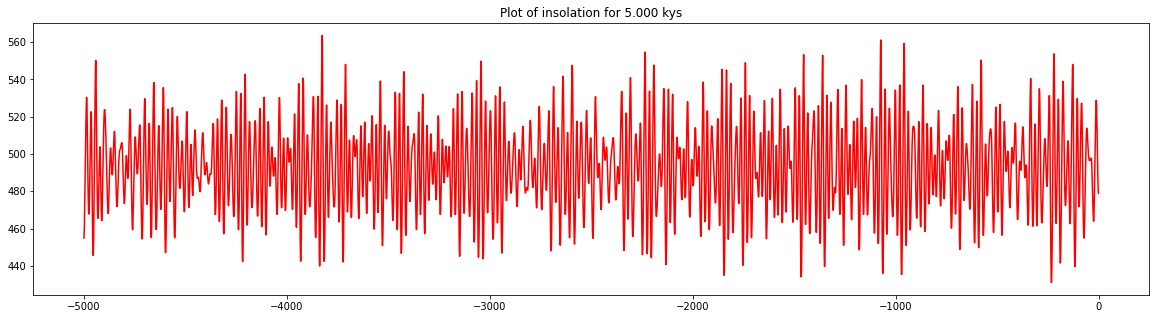

In [12]:
june_65N = np.array([daily_insolation(i, 65, 172)["Fsw"] for i in range(5000)])
plt.figure(figsize=(20,5))
plt.plot(-np.arange(1,5001,1), june_65N, color="red")
plt.title("Plot of insolation for 5.000 kys")

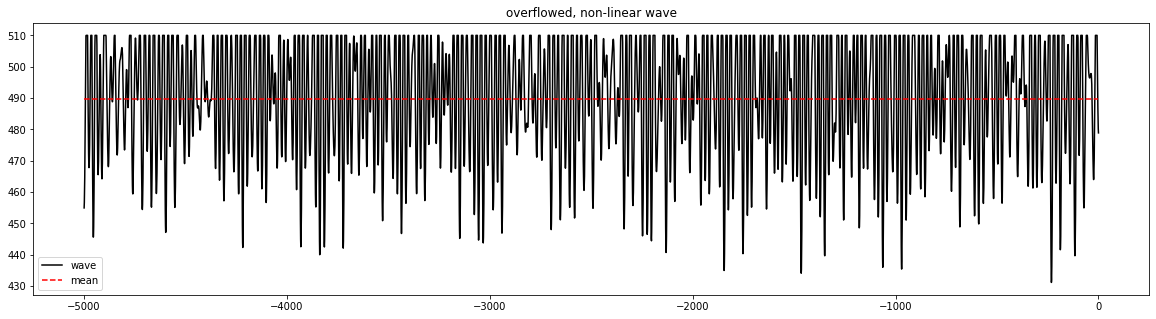

In [13]:
wave = june_65N.copy(); wave[wave > 510] = 510
plt.figure(figsize=(20,5))
plt.plot(-np.arange(0,5000,1), wave, color="black", label="wave", zorder=0)
plt.hlines(y=np.mean(wave), color="r", linestyle="--", label="mean", xmin=-5000, xmax=0, zorder=1)
plt.title("overflowed, non-linear wave")
plt.legend()

## 3.2 Plot of orbital parameters <a name="orbitparam"></a>

In [14]:
eccNew, obliquityNew, lambdaNew = [], [], []
time = -np.arange(5000)
lat, day = 65, 172
for i in -time:
    res = daily_insolation(kyear=i,lat=lat,day=day)
    eccNew.append(res["ecc"])
    obliquityNew.append(res["obliquity"])
    lambdaNew.append(res["lambda"])

Text(0.5, 1.0, 'Eccentricity at latitude 65, day 172')

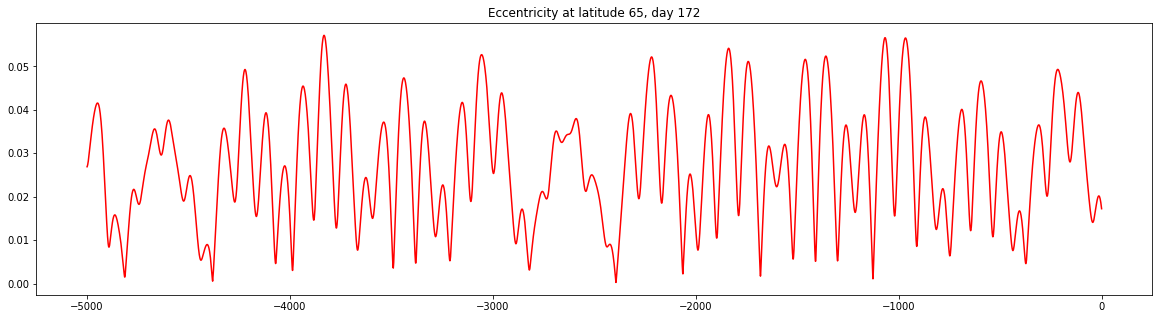

In [15]:
plt.figure(figsize=(20,5))
plt.plot(time, eccNew, label="eccentricity", color="red")
plt.title(f"Eccentricity at latitude {lat}, day {day}")

Text(0.5, 1.0, 'Obliquity at latitude 65, day 172')

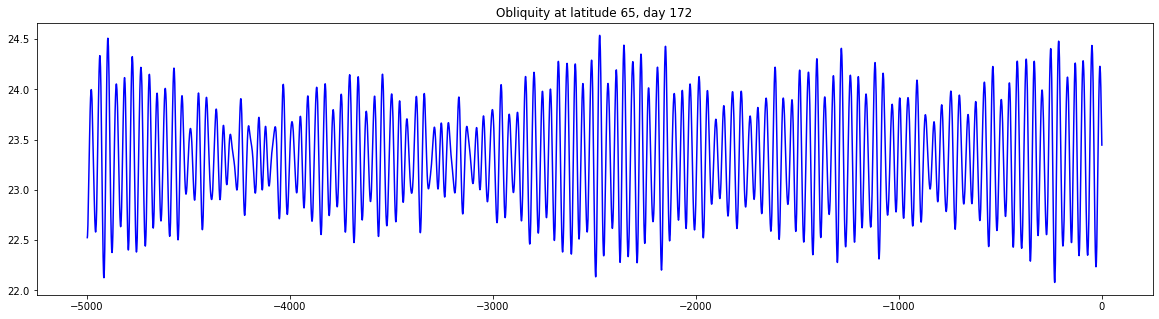

In [16]:
plt.figure(figsize=(20,5))
plt.plot(time, obliquityNew, label="obliquity", color="blue")
plt.title(f"Obliquity at latitude {lat}, day {day}")

Text(0.5, 1.0, 'Lambda at latitude 65, day 172')

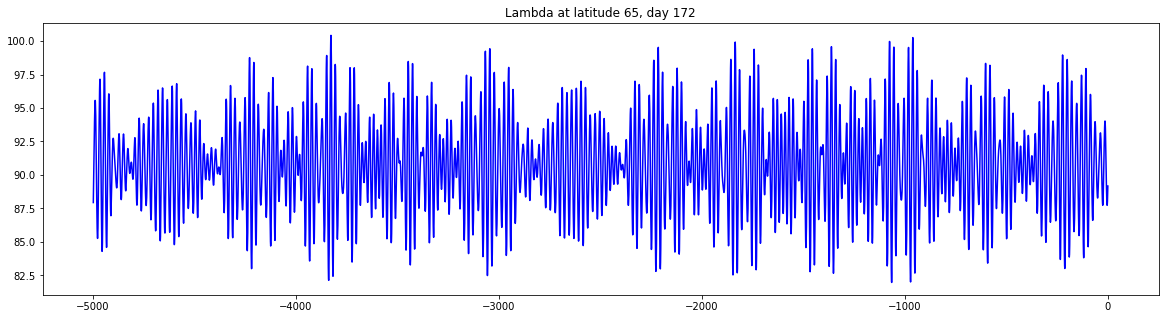

In [17]:
plt.figure(figsize=(20,5))
plt.plot(time, lambdaNew, label="lambda", color="blue")
plt.title(f"Lambda at latitude {lat}, day {day}")

{'freq': array([1.95312500e-04, 3.90625000e-04, 5.85937500e-04, ...,
        4.99609375e-01, 4.99804688e-01, 5.00000000e-01]),
 'spec': array([1.84313075e-06, 1.96490786e-06, 2.32757035e-06, ...,
        1.24806564e-11, 1.36585566e-11, 1.62338659e-11]),
 'coh': None,
 'phase': None,
 'kernel': array([0.125, 0.25 , 0.25 , 0.25 , 0.125]),
 'df': 7.9997714808043865,
 'bandwidth': 0.0002457628396898031,
 'n.used': 5120,
 'orig.n': 5001,
 'taper': 0.1,
 'pad': 0,
 'detrend': True,
 'demean': False,
 'method': 'Smoothed Periodogram'}

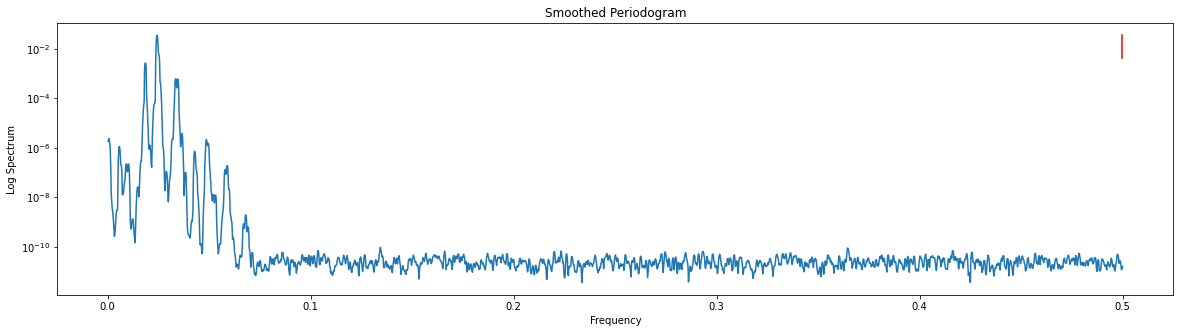

In [32]:
spec_pgram(orbital_data["epsilon"], spans=[5]) # epsilon = obliquity

{'freq': array([2.000e-04, 4.000e-04, 6.000e-04, ..., 4.996e-01, 4.998e-01,
        5.000e-01]),
 'spec': array([1.44749659e+02, 1.50013115e+02, 2.18916110e+02, ...,
        5.25913657e-02, 5.26924974e-02, 5.40773369e-02]),
 'coh': None,
 'phase': None,
 'kernel': array([0.125, 0.25 , 0.25 , 0.25 , 0.125]),
 'df': 8.190127970749542,
 'bandwidth': 0.00025166114784235834,
 'n.used': 5000,
 'orig.n': 5000,
 'taper': 0.1,
 'pad': 0,
 'detrend': True,
 'demean': False,
 'method': 'Smoothed Periodogram'}

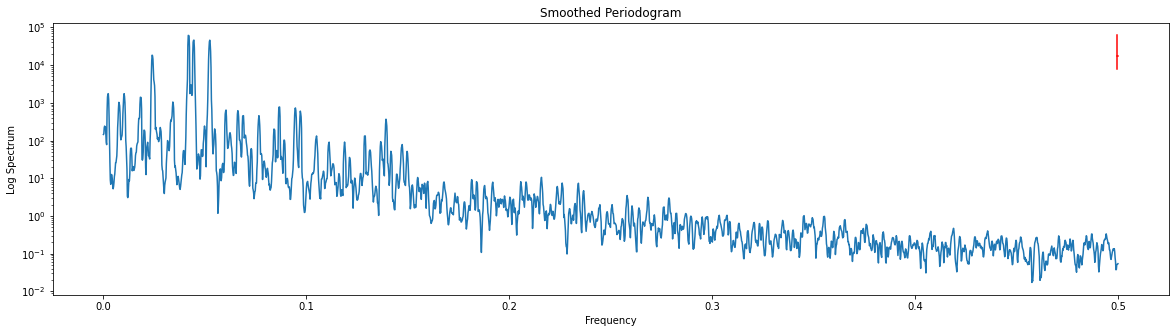

In [33]:
spec_pgram(wave, spans=[5])